# =========================================================
# FULL END-TO-END SPEECH EMOTION RECOGNITION SYSTEM
# Training + Evaluation + Real-Time Deployment
# =========================================================

## Imports

In [1]:
import os
import time
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import librosa
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import sounddevice as sd
import tkinter as tk
from tkinter import ttk

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\shavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global Configuration

In [2]:
SAMPLE_RATE = 16000
N_MELS = 64
N_FFT = 400
HOP_LENGTH = 160
MAX_FRAMES = 100     # MUST stay consistent everywhere

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Real-time parameters
WINDOW_DURATION = 1.0
STEP_DURATION = 0.3
CHUNK_DURATION = 0.1

WINDOW_SIZE = int(SAMPLE_RATE * WINDOW_DURATION)
CHUNK_SIZE = int(SAMPLE_RATE * CHUNK_DURATION)

SILENCE_RMS_THRESHOLD = 0.006
CONFIDENCE_THRESHOLD = 0.45
SMOOTHING_WINDOW = 5

MODEL_PATH = "cnn_gru_ravdess.pth"

## Emotion Mapping (RAVDESS)

In [3]:
EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

EMOTION_TO_IDX = {v: i for i, v in enumerate(EMOTION_MAP.values())}
IDX_TO_EMOTION = {i: v for v, i in EMOTION_TO_IDX.items()}
NUM_EMOTIONS = len(EMOTION_TO_IDX)

## DATASET DOWNLOAD

In [4]:
print("Downloading RAVDESS dataset...")
dataset_path = kagglehub.dataset_download(
    "uwrfkaggler/ravdess-emotional-speech-audio"
)
print("Dataset path:", dataset_path)

wav_files = []
for root, _, files in os.walk(dataset_path):
    for f in files:
        if f.endswith(".wav"):
            wav_files.append(os.path.join(root, f))

print("Total audio files:", len(wav_files))

Dataset path: C:\Users\shavi\.cache\kagglehub\datasets\uwrfkaggler\ravdess-emotional-speech-audio\versions\1
Total audio files: 2880


## FEATURE EXTRACTION

In [5]:
def extract_log_mel_from_file(file_path):
    y, _ = librosa.load(file_path, sr=SAMPLE_RATE)
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel)

    if log_mel.shape[1] < MAX_FRAMES:
        log_mel = np.pad(log_mel, ((0, 0), (0, MAX_FRAMES - log_mel.shape[1])))
    else:
        log_mel = log_mel[:, :MAX_FRAMES]

    return log_mel

## DATASET CLASS

In [6]:
class RavdessDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        filename = os.path.basename(file_path)
        emotion_id = filename.split("-")[2]
        label = EMOTION_TO_IDX[EMOTION_MAP[emotion_id]]

        features = extract_log_mel_from_file(file_path)
        features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        return features, label

## TRAIN / VAL SPLIT

In [7]:
train_files, val_files = train_test_split(
    wav_files, test_size=0.2, random_state=42, shuffle=True
)

train_loader = DataLoader(RavdessDataset(train_files), batch_size=32, shuffle=True)
val_loader = DataLoader(RavdessDataset(val_files), batch_size=32, shuffle=False)

## MODEL DEFINITION

In [8]:
class CNNGRU(nn.Module):
    def __init__(self, num_emotions):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.gru = nn.GRU(input_size=64 * 16, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, num_emotions)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, h = self.gru(x)
        return self.fc(h.squeeze(0))

model = CNNGRU(NUM_EMOTIONS).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## TRAINING & VALIDATION

In [9]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(loader), correct / total

@torch.no_grad()
def validate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item()
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    return total_loss / len(loader), correct / total, all_labels, all_preds

## TRAIN MODEL

In [10]:
NUM_EPOCHS = 25

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, _, _ = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.3f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}"
    )

torch.save(model.state_dict(), MODEL_PATH)
print("Model saved:", MODEL_PATH)

Epoch 1/25 | Train Loss: 1.8596 | Train Acc: 0.259 | Val Loss: 1.7374 | Val Acc: 0.314
Epoch 2/25 | Train Loss: 1.7482 | Train Acc: 0.309 | Val Loss: 1.7273 | Val Acc: 0.306
Epoch 3/25 | Train Loss: 1.7206 | Train Acc: 0.328 | Val Loss: 1.6951 | Val Acc: 0.314
Epoch 4/25 | Train Loss: 1.6705 | Train Acc: 0.354 | Val Loss: 1.6374 | Val Acc: 0.363
Epoch 5/25 | Train Loss: 1.6025 | Train Acc: 0.385 | Val Loss: 1.6517 | Val Acc: 0.380
Epoch 6/25 | Train Loss: 1.5346 | Train Acc: 0.424 | Val Loss: 1.5657 | Val Acc: 0.403
Epoch 7/25 | Train Loss: 1.4191 | Train Acc: 0.481 | Val Loss: 1.4910 | Val Acc: 0.436
Epoch 8/25 | Train Loss: 1.3032 | Train Acc: 0.543 | Val Loss: 1.5599 | Val Acc: 0.411
Epoch 9/25 | Train Loss: 1.1360 | Train Acc: 0.623 | Val Loss: 1.2702 | Val Acc: 0.542
Epoch 10/25 | Train Loss: 1.0006 | Train Acc: 0.678 | Val Loss: 1.1996 | Val Acc: 0.601
Epoch 11/25 | Train Loss: 0.8257 | Train Acc: 0.745 | Val Loss: 1.0938 | Val Acc: 0.623
Epoch 12/25 | Train Loss: 0.6715 | Train 

TRAINING CURVES

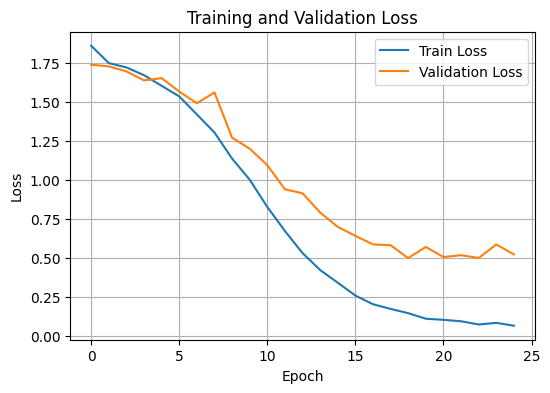

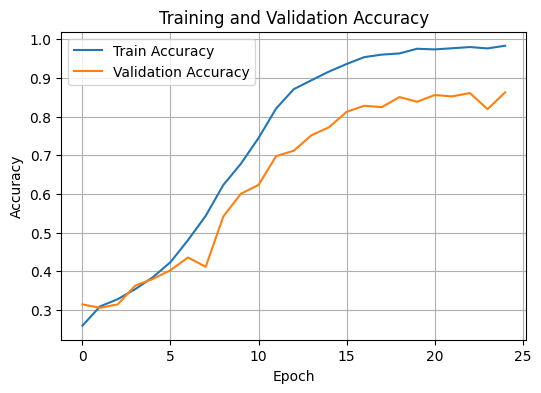

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## EVALUATION

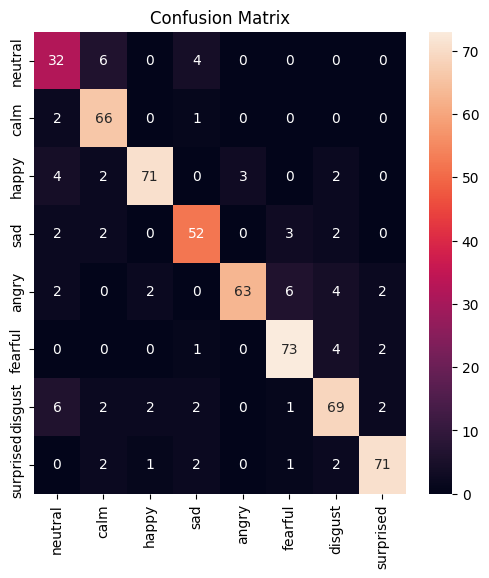

              precision    recall  f1-score   support

     neutral       0.67      0.76      0.71        42
        calm       0.82      0.96      0.89        69
       happy       0.93      0.87      0.90        82
         sad       0.84      0.85      0.85        61
       angry       0.95      0.80      0.87        79
     fearful       0.87      0.91      0.89        80
     disgust       0.83      0.82      0.83        84
   surprised       0.92      0.90      0.91        79

    accuracy                           0.86       576
   macro avg       0.86      0.86      0.85       576
weighted avg       0.87      0.86      0.86       576



In [12]:
_, _, y_true, y_pred = validate(model, val_loader)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=IDX_TO_EMOTION.values(),
            yticklabels=IDX_TO_EMOTION.values())
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=IDX_TO_EMOTION.values()))

## REAL-TIME FEATURE EXTRACTION

In [13]:
def extract_log_mel_from_audio(audio):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel)
    if log_mel.shape[1] < MAX_FRAMES:
        log_mel = np.pad(log_mel, ((0,0),(0,MAX_FRAMES-log_mel.shape[1])))
    else:
        log_mel = log_mel[:, :MAX_FRAMES]
    return log_mel

def is_speech(audio):
    return np.sqrt(np.mean(audio**2)) > SILENCE_RMS_THRESHOLD

## REAL-TIME STATE

In [14]:
audio_buffer = np.zeros(0, dtype=np.float32)
emotion_history = deque(maxlen=SMOOTHING_WINDOW)

current_emotion = "Listening..."
current_probs = np.zeros(NUM_EMOTIONS)
current_latency = 0.0

last_inference_time = 0
running = False
stream = None

## AUDIO CALLBACK

In [15]:
def audio_callback(indata, frames, time_info, status):
    global audio_buffer, last_inference_time
    global current_emotion, current_probs, current_latency

    if not running:
        return

    audio_buffer = np.concatenate((audio_buffer, indata[:,0]))
    audio_buffer = audio_buffer[-WINDOW_SIZE:]

    now = time.time()
    if len(audio_buffer) < WINDOW_SIZE:
        return
    if now - last_inference_time < STEP_DURATION:
        return

    last_inference_time = now

    if not is_speech(audio_buffer):
        current_emotion = "Listening..."
        current_probs[:] = 0
        emotion_history.clear()
        return

    features = extract_log_mel_from_audio(audio_buffer)
    x = torch.tensor(features).unsqueeze(0).unsqueeze(0).to(DEVICE)

    start = time.time()
    with torch.no_grad():
        probs = torch.softmax(model(x), dim=1).cpu().numpy()[0]

    emotion_history.append(np.argmax(probs))
    final = max(set(emotion_history), key=emotion_history.count)

    current_emotion = IDX_TO_EMOTION[final]
    current_probs = probs
    current_latency = (time.time() - start) * 1000

# GUI

In [16]:
root = tk.Tk()
root.title("Real-Time Speech Emotion Recognition")
root.geometry("420x420")

emotion_label = ttk.Label(root, text="Emotion: ---", font=("Helvetica", 16))
emotion_label.pack(pady=10)

latency_label = ttk.Label(root, text="Latency: --- ms")
latency_label.pack()

bars = []
for e in IDX_TO_EMOTION.values():
    frame = ttk.Frame(root)
    frame.pack(fill="x", padx=20, pady=2)
    ttk.Label(frame, text=e, width=10).pack(side="left")
    bar = ttk.Progressbar(frame, maximum=1.0)
    bar.pack(side="left", fill="x", expand=True)
    bars.append(bar)

def update_gui():
    emotion_label.config(text=f"Emotion: {current_emotion}")
    latency_label.config(text=f"Latency: {current_latency:.1f} ms")
    for i, bar in enumerate(bars):
        bar["value"] = current_probs[i]
    root.after(100, update_gui)

def start_listening():
    global running, stream, audio_buffer
    if running:
        return
    running = True
    audio_buffer = np.zeros(0, dtype=np.float32)
    stream = sd.InputStream(
        samplerate=SAMPLE_RATE,
        channels=1,
        blocksize=CHUNK_SIZE,
        callback=audio_callback
    )
    stream.start()

def stop_listening():
    global running, stream
    running = False
    if stream:
        stream.stop()
        stream.close()
        stream = None

ttk.Button(root, text="Start", command=start_listening).pack(pady=5)
ttk.Button(root, text="Stop", command=stop_listening).pack(pady=5)

update_gui()
root.mainloop()
